In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import time as t
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set_style("whitegrid", {'axes.grid' : False})
import os
os.chdir('C:/Users/Jack Wills/Documents/Portfolio/Projects/LoL Champ Classification')

In [4]:
# For any URL, return the JSON
def return_json(URL, session):
    while True:
        response = session.get(URL)
        try:
            # Check for 404 error and quit if received
            if response.json()['status']['status_code'] == 404:
                return "error - status code 404"
            # Check for 429 (too many requests made), sleep if received
            elif response.json()['status']['status_code'] == 429:
                t.sleep(10)
                continue
            else:
                return "error - unknown reason"
        except:
            break
    return response.json()

# Provide the match-id & region, receive the json of match timeline (1 minute interval of match data)
def get_matchTimeline(matchId, region, key, session):
    URL = 'https://' + region + '.api.riotgames.com/lol/match/v4/timelines/by-match/' + str(
        matchId) + '/?api_key=' + key
    json = return_json(URL, session)
    return json


# Provide the match-id & region, receive the match information (game length, participants etc..)
def get_gameInfo(matchId, region, key, session):
    URL = 'https://' + region + '.api.riotgames.com/lol/match/v4/matches/' + str(matchId) + '/?api_key=' + key
    json = return_json(URL, session)
    return json

# Decide how much data to gather in each elo
def set_volume(tier):
    tier_list = {
        'DIAMOND': 8,
        'GOLD': 1,
        'SILVER': 1
    }
    size = tier_list[tier]
    return size

# Loop to get summoner IDs from given regions / tiers
def get_summoners(fullRegionList, tierList, key, session):
    summonerIds, summonerRegions, summonerTier = [], [], []
    for y in fullRegionList:
        for z in range(len(tierList)):
            size = set_volume(tierList[z][0])
            for x in range(size):
                page = x + 1
                URL_ids = ('https://' + y + '.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/' +
                           tierList[z][0] + '/' + tierList[z][1] + '/?page=' + str(page) + '&api_key=' + key)
                json = return_json(URL_ids, session)
                for x in range(0, len(json)):
                    summonerIds.append(json[x]['summonerId'])
                    summonerRegions.append(y)
                    summonerTier.append(tierList[z][0])
    return summonerIds, summonerRegions, summonerTier

# Convert a list of names to IDs
def name_to_id(selectedIds, selectedRegions, selectedTiers,  key, session):
    accountIds, accountRegions, accountTiers = [], [], []
    for i in range(len(selectedIds)):
        URL = 'https://' + selectedRegions[i] + '.api.riotgames.com/lol/summoner/v4/summoners/' + selectedIds[
            i] + '/?api_key=' + key
        json = return_json(URL, session)
        account_id = json['accountId']
        accountIds.append(account_id)
        accountRegions.append(selectedRegions[i])
        accountTiers.append(selectedTiers[i])
    return accountIds, accountRegions, accountTiers

# Python code to remove duplicate elements
def remove_duplicates(list1, list2, list3):
    final_list1 = []
    final_list2 = []
    final_list3 = []
    for i in range(len(list1)):
        if list1[i] not in final_list1:
            final_list1.append(list1[i])
            final_list2.append(list2[i])
            final_list3.append(list3[i])
    return final_list1, final_list2, final_list3


def time_conv(yyyy, mm, dd):
    sd = datetime.date(yyyy, mm, dd) - datetime.timedelta(7)
    time = t.mktime(sd.timetuple())
    time = str(int(time)) + "000"
    return time
    
def get_matchIds(accountIds, accountRegions, accountTiers, key, session):
    matchIds, matchTiers, matchRegions = [], [], []
    start_time = time_conv(2020, 1, 1)
    for i in range(len(accountIds)):
        URL = 'https://' + accountRegions[i] + '.api.riotgames.com/lol/match/v4/matchlists/by-account/' + accountIds[
            i] + '/?beginTime=' + start_time + '&queue=420' + '&api_key=' + key
        try:
            match_json = return_json(URL, session) 
            for match in match_json['matches']:
                matchIds.append(match['gameId'])
                matchRegions.append(accountRegions[i])
                matchTiers.append(accountTiers[i])
        except:
            pass
    return matchIds, matchRegions, matchTiers

def main(fullRegionList, tierList, key, session):
    summonerIds, summonerRegions, summonerTiers = get_summoners(fullRegionList, tierList, key, session)
    print(str(len(summonerIds)) + " summoners found. Transforming to account IDs.")
    accountIds, accountRegions, accountTiers = name_to_id(summonerIds, summonerRegions, summonerTiers,  key, session)
    print(str(len(accountIds)) + " account IDs successfully transformed. Getting match IDs.")
    matchIds, matchRegions, matchTiers = get_matchIds(accountIds, accountRegions, accountTiers, key, session)
    print(str(len(matchIds)) + " game IDs found, converting to data.")
    return matchIds, matchRegions, matchTiers

In [6]:
def laner_check(json, game_length):
    total_cs = json['stats']['totalMinionsKilled']
    cspm = total_cs / (game_length / 60)
    if cspm > 4.5:
        return True
    else:
        return False
    
def get_team_data(features, matchId, matchRegion, matchTier, key, session):
    URL = 'https://' + matchRegion + '.api.riotgames.com/lol/match/v4/matches/' + str(matchId) + '/?api_key=' + key
    json = return_json(URL, session)
    
    game_duration = json['gameDuration']
    all_team_stats = []
    for player in json['participants']:
        player_stats = []
        if laner_check(player, game_duration):
            for stat in features:
                player_stats.append(player['stats'][stat])
            player_stats.insert(0, matchTier)
            player_stats.insert(0, player['championId'])
            all_team_stats.append(player_stats)
    return all_team_stats

def gameIds_to_data(matchIds, matchRegions, matchTiers, key, session):

    features = ['kills', 'deaths', 'assists', 'largestKillingSpree', 'largestMultiKill', 'killingSprees', 'longestTimeSpentLiving',
    'totalDamageDealt', 'magicDamageDealt', 'physicalDamageDealt', 'trueDamageDealt', 'largestCriticalStrike', 
    'totalDamageDealtToChampions', 'magicDamageDealtToChampions', 'trueDamageDealtToChampions', 'totalHeal', 'damageSelfMitigated',
    'damageDealtToObjectives', 'damageDealtToTurrets', 'timeCCingOthers', 'totalDamageTaken', 'goldEarned', 'turretKills', 
    'inhibitorKills', 'totalMinionsKilled', 'totalTimeCrowdControlDealt']
    
    all_stats = []
    for i in range(len(matchIds)):
        if i % 1000 == 0:
            print(i)
        try:
            all_stats.extend(get_team_data(features, matchIds[i], matchRegions[i], matchTiers[i], key, session))
        except:
            pass
    col = ['Champ ID', 'Tier'] + features
    df = pd.DataFrame(all_stats, columns = col)  
    return df

def full(fullRegionList, tierList, key, session):
    matchIds, matchRegions, matchTiers = main(fullRegionList, tierList, key, session)
    df = gameIds_to_data(matchIds, matchRegions, matchTiers, key, session)
    return df

In [7]:
regions = [
    'euw1',
]

tiers = [
    ['DIAMOND', 'III'],
]

key = 'RGAPI-b465689b-1158-4fd0-99f7-a33c7b39133b'
session = requests.Session()

df = full(regions, tiers, key, session)

1640 summoners found. Transforming to account IDs.
1640 account IDs successfully transformed. Getting match IDs.
158819 game IDs found, converting to data.
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
13600

In [8]:
df.to_csv('champ_data.csv')

In [55]:
df = pd.read_csv('champ_data.csv')

In [64]:
count_df = df.groupby('Champ ID').count()
vol_champs = list(count_df[count_df['Tier'] > 100].index)
agg_df = df.groupby('Champ ID').mean()
final_df = agg_df[agg_df.index.isin(vol_champs)]
final_df = final_df.drop(['Unnamed: 0'], axis = 1)

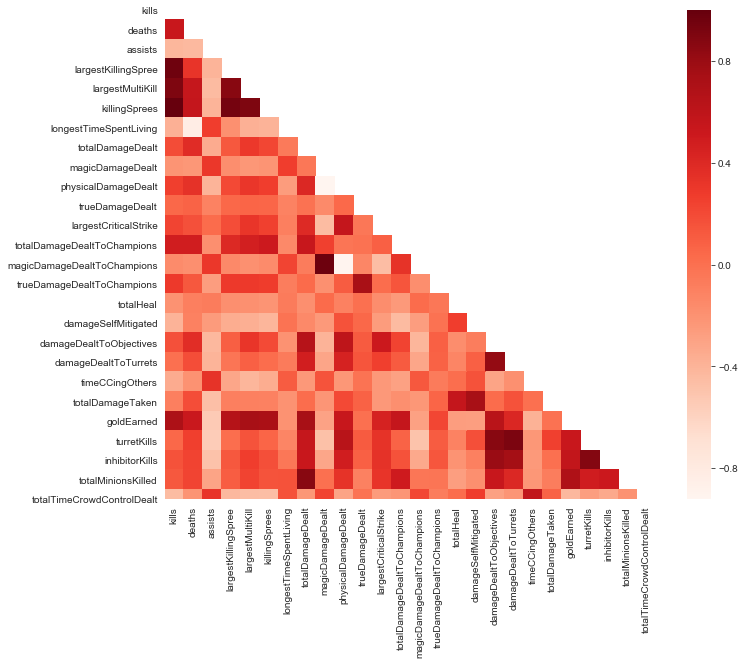

In [66]:
corr_all = final_df.corr()
f, ax = plt.subplots(figsize = (11, 9))
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, cmap="Reds", mask=mask)

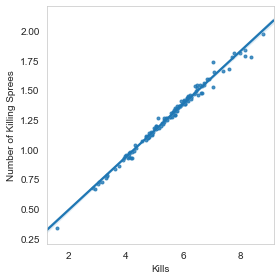

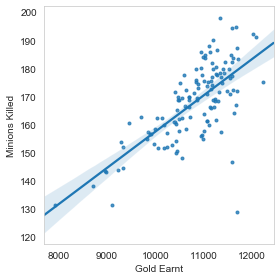

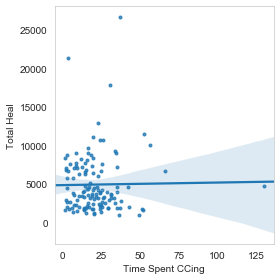

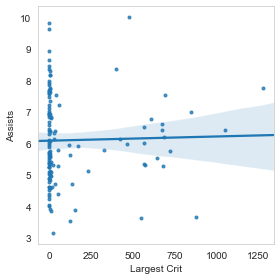

In [67]:
# Pick some variables to compare 
X1=np.array(final_df.kills.values)
Y1=np.array(final_df.killingSprees.values)

X2=np.array(final_df.goldEarned.values)
Y2=np.array(final_df.totalMinionsKilled.values)

X3=np.array(final_df.timeCCingOthers.values)
Y3=np.array(final_df.totalHeal.values)

X4=np.array(final_df.largestCriticalStrike.values)
Y4=np.array(final_df.assists.values)

# Create loopable list
Xs = [X1, X2, X3, X4]
X_labels = ['Kills','Gold Earnt','Time Spent CCing','Largest Crit']
Ys = [Y1, Y2, Y3, Y4]
Y_labels = ['Number of Killing Sprees','Minions Killed','Total Heal','Assists']

# Loop through and plot each one
for i in range(4):
    plt.figure(figsize=(4,4))
    sns.regplot(list(Xs[i]), list(Ys[i]), data= final_df, marker='.')
    plt.xlabel(X_labels[i])
    plt.ylabel(Y_labels[i])
    plt.tight_layout()

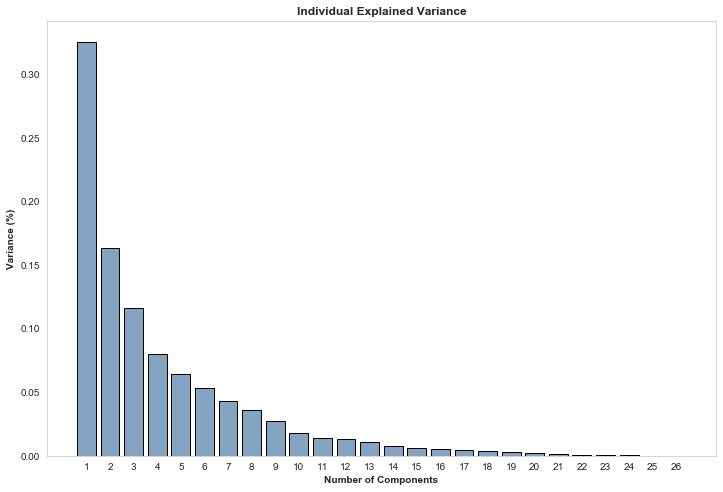

In [68]:
num_features = 26

# Standardizing the features
df_std = pd.DataFrame(StandardScaler().fit_transform(final_df))
df_std.columns = final_df.columns

# Fit all 17 components for variance plotting
pca = PCA(n_components= num_features)
principalComponents = pca.fit_transform(df_std)
principalDf = pd.DataFrame(data = principalComponents)
pca_str = pca.explained_variance_ratio_

# Plot the variance of each PC
plt.figure(figsize=(12,8))
plt.bar(np.arange(1, num_features + 1), pca_str, color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
plt.xticks(np.arange(1, num_features + 1))
plt.xlabel('Number of Components',fontweight='bold')
plt.ylabel('Variance (%)',fontweight='bold')
plt.title('Individual Explained Variance',fontweight='bold')
plt.show()


Text(0.5, 1.0, 'Variable Influence on Principle Component 1')

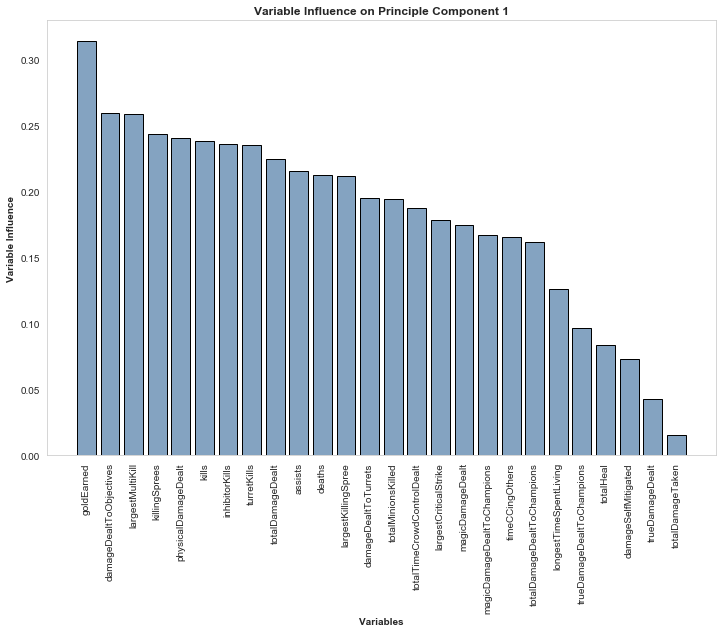

In [69]:
# Create a table of all the feature strengths for each component
all_comps = []
for i in range(num_features):
    all_comps.append(pca.components_[i])
var_str = pd.DataFrame(all_comps, columns= final_df.columns, index=range(1, num_features + 1)).abs().transpose()

# Check it worked
var_str.head(5)

# Plot the varialbes in PC1
plt.figure(figsize=(12,8))
plt.bar(var_str.sort_values(1,ascending=False)[1].keys(),var_str.sort_values(1,ascending=False)[1],color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('Variables',fontweight='bold')
plt.ylabel('Variable Influence',fontweight='bold')
plt.title('Variable Influence on Principle Component 1',fontweight='bold')

In [70]:
actual_str = pd.DataFrame(all_comps, columns= final_df.columns, index=range(1, num_features + 1)).transpose()

In [71]:
# Print out the strongest variables for the top 9 PCs
for i in range(1,9):
    print("")
    print("PC "+str(i))
    for j in range(5):
        key = var_str.sort_values(i, ascending=False)[i].keys()[j]
        if actual_str[actual_str.index == key][i].values[0] > 0:
            direction = 'High'
        else:
            direction = 'Low'
        print(direction, key)


PC 1
Low goldEarned
Low damageDealtToObjectives
Low largestMultiKill
Low killingSprees
Low physicalDamageDealt

PC 2
High turretKills
High damageSelfMitigated
Low kills
Low killingSprees
Low largestKillingSpree

PC 3
High totalMinionsKilled
High totalDamageDealt
High magicDamageDealt
Low totalDamageTaken
High longestTimeSpentLiving

PC 4
Low totalDamageTaken
High largestCriticalStrike
High assists
Low magicDamageDealtToChampions
Low magicDamageDealt

PC 5
High trueDamageDealt
High trueDamageDealtToChampions
High longestTimeSpentLiving
Low deaths
Low totalHeal

PC 6
Low longestTimeSpentLiving
High deaths
High timeCCingOthers
High totalTimeCrowdControlDealt
Low totalHeal

PC 7
High totalTimeCrowdControlDealt
High longestTimeSpentLiving
High timeCCingOthers
High totalMinionsKilled
High damageSelfMitigated

PC 8
High totalHeal
High largestCriticalStrike
High totalDamageDealt
Low inhibitorKills
Low damageDealtToTurrets


In [72]:
# Refit with 2 components
pca_best = PCA(n_components=2)
best_comps = pca_best.fit_transform(df_std)

In [73]:
x = [x[0] for x in best_comps]
y = [y[1] for y in best_comps]

In [74]:
champ_df = pd.read_csv('champ_ids.csv')

In [77]:
# Add some flare to the data (real names/lanes)
lanes = []
champs = []

for i in final_df.index:
    row = champ_df[champ_df['ID'] == i]
    lanes.append(row['Lane'].values[0])
    champs.append(row['Champion'].values[0])

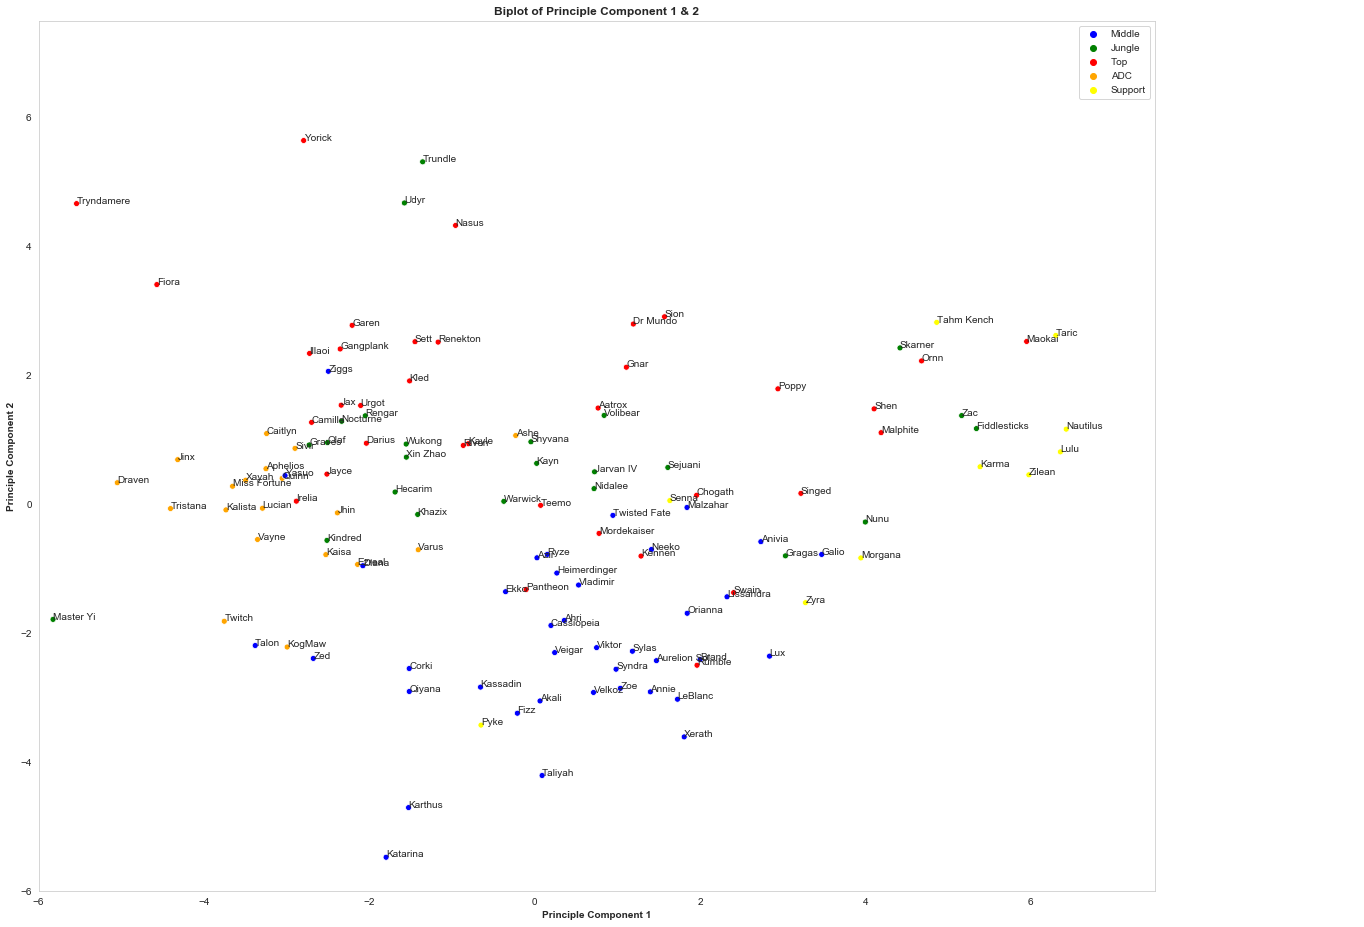

In [78]:
plt.figure(figsize=(20,16))
plt.xlim(-6,7.5)
plt.ylim(-6,7.5)
plt.xlabel("Principle Component {}".format(1),fontweight='bold')
plt.ylabel("Principle Component {}".format(2),fontweight='bold')
plt.title('Biplot of Principle Component 1 & 2',fontweight='bold')
ax = sns.scatterplot(x, y, hue = lanes, palette = ['Blue', 'Green', 'Red', 'Orange', 'Yellow'])

for i, txt in enumerate(champs):
    ax.annotate(txt, (x[i], y[i]))